# Does symbolic regression depend on dynamical properties?
The dysts database contains over 100 chaotic systems, and we will investigate a subset of the systems that are polynomially nonlinear, with highest polynomial degree <= 4. All of the following 70 systems are bounded and exhibit strange attractors.

Dynamical properties of interest include:
1. Level of chaos, as measured by the largest Lyapunov exponent,
2. Scale separation, as measured by the ratio of the "dominant" timescale to the "minimum significant" time scale (see William Gilpin's dysts paper),
3. Syntactical complexity, as measured by the description length metric,
4. Degree of nonlinearity, measured as the highest polynomially nonlinearity appearing in the governing equations. 

In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from scipy.integrate import odeint
from sklearn.metrics import mean_squared_error
from dysts.base import make_trajectory_ensemble
from dysts.base import get_attractor_list
import dysts.flows as flows
import dysts.datasets as datasets
import time

from utils import *

import pysindy as ps

# Ignore warnings
# import warnings
# warnings.filterwarnings('ignore')

# Seed the random number generators for reproducibility
np.random.seed(100)

# Chaotic System Initialization

This experiment include 70 chaotic, polynomially nonlinear systems provided by the database from William Gilpin. "Chaos as an interpretable benchmark for forecasting and data-driven modelling" Advances in Neural Information Processing Systems (NeurIPS) 2021 https://arxiv.org/abs/2110.05266.

In [2]:
t1 = time.time()

# Arneodo does not have the Lyapunov spectrum calculated so omit it.
# HindmarshRose and AtmosphericRegime seem to be poorly sampled
# by the dt and dominant time scales used in the database, so we omit them.
systems_list = ["Aizawa", "Bouali2", 
                "GenesioTesi", "HyperBao", "HyperCai", "HyperJha", 
                "HyperLorenz", "HyperLu", "HyperPang", "Laser",
                "Lorenz", "LorenzBounded", "MooreSpiegel", "Rossler", "ShimizuMorioka",
                "HenonHeiles", "GuckenheimerHolmes", "Halvorsen", "KawczynskiStrizhak",
                "VallisElNino", "RabinovichFabrikant", "NoseHoover", "Dadras", "RikitakeDynamo",
                "NuclearQuadrupole", "PehlivanWei", "SprottTorus", "SprottJerk", "SprottA", "SprottB",
                "SprottC", "SprottD", "SprottE", "SprottF", "SprottG", "SprottH", "SprottI", "SprottJ",
                "SprottK", "SprottL", "SprottM", "SprottN", "SprottO", "SprottP", "SprottQ", "SprottR",
                "SprottS", "Rucklidge", "Sakarya", "RayleighBenard", "Finance", "LuChenCheng",
                "LuChen", "QiChen", "ZhouChen", "BurkeShaw", "Chen", "ChenLee", "WangSun", "DequanLi",
                "NewtonLiepnik", "HyperRossler", "HyperQi", "Qi", "LorenzStenflo", "HyperYangChen", 
                "HyperYan", "HyperXu", "HyperWang", "Hadley",
               ]
alphabetical_sort = np.argsort(systems_list)
systems_list = np.array(systems_list)[alphabetical_sort]

# attributes list
attributes = [
    "maximum_lyapunov_estimated",
    "lyapunov_spectrum_estimated",
    "embedding_dimension",
    "parameters",
    "dt",
    "hamiltonian",
    "period",
    "unbounded_indices"
]

# Get attributes
all_properties = dict()
for i, equation_name in enumerate(systems_list):
    eq = getattr(flows, equation_name)()
    attr_vals = [getattr(eq, item, None) for item in attributes]
    all_properties[equation_name] = dict(zip(attributes, attr_vals))
    # print(i, equation_name, all_properties[equation_name])
    
n = 1000
pts_per_period = 100
n_trajectories = 5
# Get training and testing trajectories for all the experimental systems 
all_sols_train, all_t_train, all_sols_test, all_t_test = load_data(
    systems_list, all_properties, 
    n=n, pts_per_period=pts_per_period,
    random_bump=False,
    n_trajectories=n_trajectories
)
test_trajectories, test_trajectories_time = make_test_trajectories(
    systems_list,
    all_properties,
    n=n,
    pts_per_period=pts_per_period,
    random_bump=False,
    include_transients=False,
    approximate_center=0.0,  # approximate center of the attractor
    n_trajectories=n_trajectories,
)
        
t2 = time.time()
print('Took ', t2 - t1, ' seconds to load the systems')

0 Aizawa(name='Aizawa', params={'a': 0.95, 'b': 0.7, 'c': 0.6, 'd': 3.5, 'e': 0.25, 'f': 0.1}, random_state=None)
1 Bouali2(name='Bouali2', params={'a': 3.0, 'b': 2.2, 'bb': 0, 'c': 0, 'g': 1.0, 'm': -0.0026667, 'y0': 1.0}, random_state=None)
2 BurkeShaw(name='BurkeShaw', params={'e': 13, 'n': 10}, random_state=None)
3 Chen(name='Chen', params={'a': 35, 'b': 3, 'c': 28}, random_state=None)
4 ChenLee(name='ChenLee', params={'a': 5, 'b': -10, 'c': -0.38}, random_state=None)
5 Dadras(name='Dadras', params={'c': 2.0, 'e': 9.0, 'o': 2.7, 'p': 3.0, 'r': 1.7}, random_state=None)
6 DequanLi(name='DequanLi', params={'a': 40, 'c': 1.833, 'd': 0.16, 'eps': 0.65, 'f': 20, 'k': 55}, random_state=None)
7 Finance(name='Finance', params={'a': 0.001, 'b': 0.2, 'c': 1.1}, random_state=None)
8 GenesioTesi(name='GenesioTesi', params={'a': 0.44, 'b': 1.1, 'c': 1}, random_state=None)
9 GuckenheimerHolmes(name='GuckenheimerHolmes', params={'a': 0.4, 'b': 20.25, 'c': 3, 'd': 1.6, 'e': 1.7, 'f': 0.44}, random_

22 HyperXu(name='HyperXu', params={'a': 10, 'b': 40, 'c': 2.5, 'd': 2, 'e': 16}, random_state=None)
23 HyperYan(name='HyperYan', params={'a': 37, 'b': 3, 'c': 26, 'd': 38}, random_state=None)
24 HyperYangChen(name='HyperYangChen', params={'a': 30, 'b': 3, 'c': 35, 'd': 8}, random_state=None)
25 KawczynskiStrizhak(name='KawczynskiStrizhak', params={'beta': -0.4, 'gamma': 0.49, 'kappa': 0.2, 'mu': 2.1}, random_state=None)
26 Laser(name='Laser', params={'a': 10.0, 'b': 1.0, 'c': 5.0, 'd': -1.0, 'h': -5.0, 'k': -6.0}, random_state=None)
27 Lorenz(name='Lorenz', params={'beta': 2.667, 'rho': 28, 'sigma': 10}, random_state=None)
28 LorenzBounded(name='LorenzBounded', params={'beta': 2.667, 'r': 64, 'rho': 28, 'sigma': 10}, random_state=None)
29 LorenzStenflo(name='LorenzStenflo', params={'a': 2, 'b': 0.7, 'c': 26, 'd': 1.5}, random_state=None)
30 LuChen(name='LuChen', params={'a': 36, 'b': 3, 'c': 18}, random_state=None)
31 LuChenCheng(name='LuChenCheng', params={'a': -10, 'b': -4, 'c': 18.1

# Calculate the true coefficients
Function from utils.py file reads in all the dysts database functions defining the systems of ODEs, and extracts all the coefficients.

In [3]:
num_attractors = len(systems_list)

lyap_list = []
dimension_list = []
param_list = []
# Calculate scale separation
scale_list_avg = []
scale_list = []
linear_scale_list = []

for system in systems_list:
    lyap_list.append(all_properties[system]['maximum_lyapunov_estimated'])
    dimension_list.append(all_properties[system]['embedding_dimension'])
    param_list.append(all_properties[system]['parameters'])
    
    # Ratio of dominant (average) to smallest timescales
    scale_list_avg.append(all_properties[system]['period'] / all_properties[system]['dt'])


true_coefficients = make_dysts_true_coefficients(systems_list, 
                                                 all_sols_train, 
                                                 dimension_list, 
                                                 param_list)
nonlinearities = nonlinear_terms_from_coefficients(true_coefficients)

# Want ratio of largest to smallest LINEAR or LYAPUNOV EXPONENT timescales 
for i, system in enumerate(systems_list):
    linear_coefs = true_coefficients[i][:, :dimension_list[i]] 
    max_linear = np.max(abs(linear_coefs))
    min_linear = np.min(abs(linear_coefs[linear_coefs != 0.0]))
    linear_scale_list.append(max_linear / min_linear)
    # print(all_properties[system]['lyapunov_spectrum_estimated'])
    sorted_spectrum = np.sort((np.array(all_properties[system]['lyapunov_spectrum_estimated'])))
    # print(sorted_spectrum, np.sum(np.array(sorted_spectrum > 0.0, dtype=int)))
    lambda_max = sorted_spectrum[-1]
    lambda_min = sorted_spectrum[0]

    #print(i, system, all_properties[system]['lyapunov_spectrum_estimated'])
    scale_list.append(lambda_max / lambda_min)
    # print(i, system, scale_list[i])


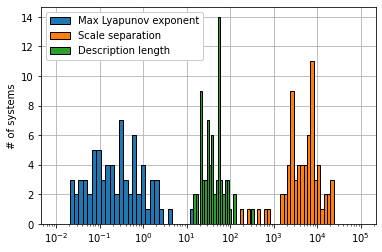

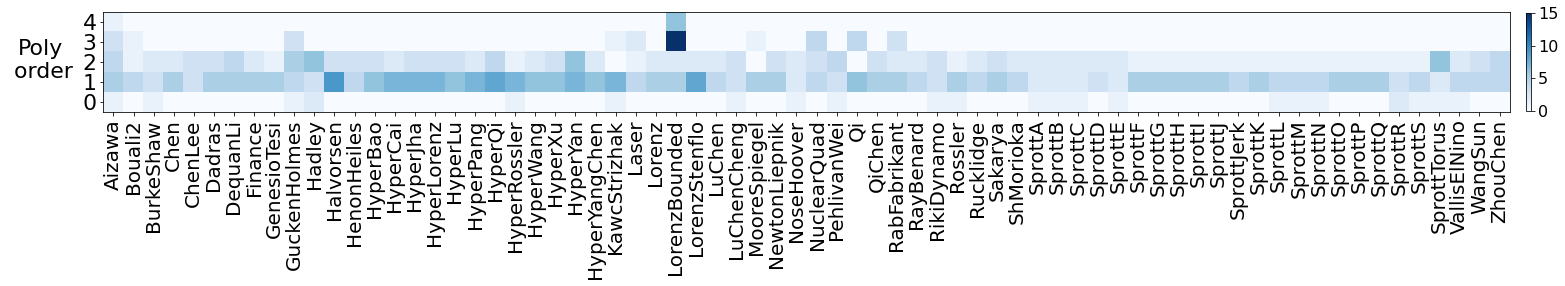

In [4]:
from complexity_calculator import compute_medl
from matplotlib.colors import LogNorm

medl_list = compute_medl(systems_list, all_sols_train, param_list)

systems_list_cleaned = []
for i, system in enumerate(systems_list):
    if system == "GuckenheimerHolmes":
        systems_list_cleaned.append("GuckenHolmes")
    elif system == "NuclearQuadrupole":
        systems_list_cleaned.append("NuclearQuad")
    elif system == "RabinovichFabrikant":
        systems_list_cleaned.append("RabFabrikant")
    elif system == "KawczynskiStrizhak":
        systems_list_cleaned.append("KawcStrizhak")
    elif system == "RikitakeDynamo":
        systems_list_cleaned.append("RikiDynamo")
    elif system == "ShimizuMorioka":
        systems_list_cleaned.append("ShMorioka")
    elif system == "HindmarshRose":
        systems_list_cleaned.append("Hindmarsh")
    elif system == "RayleighBenard":
        systems_list_cleaned.append("RayBenard")
    else:
        systems_list_cleaned.append(system)
    
plt.figure()
medl_levels = np.logspace(1, 3, 40)
lyap_levels = np.logspace(-2, 2, 40)
scale_levels = np.logspace(2, 5, 40)

plt.hist(lyap_list, bins=lyap_levels, ec='k') #, log=True)
plt.hist(scale_list_avg, bins=scale_levels, ec='k') #, log=True)
plt.hist(medl_list, bins=medl_levels, ec='k') #, log=True)
plt.xlabel('')
plt.ylabel('# of systems')
plt.legend(['Max Lyapunov exponent', 'Scale separation', 'Description length'],
           framealpha=1.0)
plt.xscale('log')
plt.grid(True)
ax = plt.gca()
ax.set_axisbelow(True)
plt.savefig('metrics.pdf')

plt.figure(figsize=(30, 6))
plt.imshow(nonlinearities.T, aspect='equal', origin='lower', cmap='Blues')
plt.xticks(np.arange(num_attractors), rotation="vertical", fontsize=20)
ax = plt.gca()
plt.xlim(-0.5, num_attractors - 0.5)
ax.set_xticklabels(np.array(systems_list_cleaned))
plt.yticks(np.arange(5), fontsize=22)
plt.colorbar(shrink=0.3, pad=0.01).ax.tick_params(labelsize=16)
plt.ylabel('Poly\n order', rotation=0, fontsize=22)
ax.yaxis.set_label_coords(-0.045, 0.3)
plt.savefig('nonlinearity.pdf')

## Trajectory Visualization
Visualizing the training and testing trajectories helps us verify if the time series data is coming from the strange attractors or from transients in the evolution.

Took  6.021281957626343  seconds to plot the systems


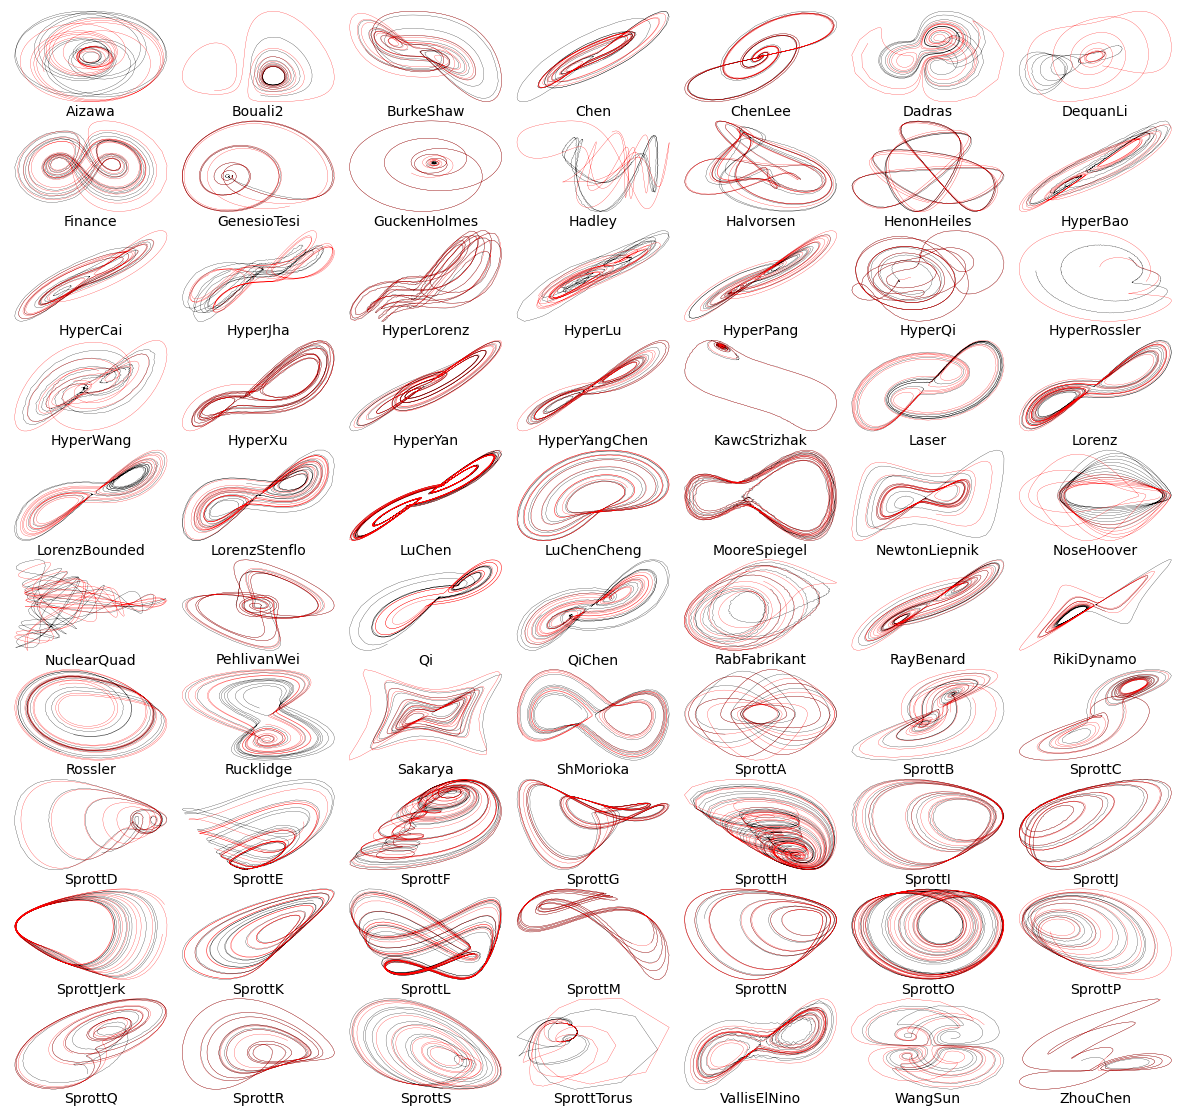

In [5]:
t1 = time.time()

# add some Gaussian noise
noise_level = 0.5

# Plot the training and testing trajectories for all the chaotic systems
num_cols = 7
num_rows = int(np.ceil(num_attractors / num_cols))
fig = plt.figure(figsize=(num_cols * 3, num_rows * 2))

gs = plt.matplotlib.gridspec.GridSpec(num_rows, num_cols)
gs.update(wspace=0.0, hspace=0.1) 

for i, attractor_name in enumerate(systems_list):
    
    x_train = all_sols_train[attractor_name][0]
    rmse = mean_squared_error(x_train, np.zeros(x_train.shape), squared=False)
    x_train += np.random.normal(0, rmse / 100.0 * noise_level, x_train.shape)
    x_test = all_sols_test[attractor_name][0]
    t_train = all_t_train[attractor_name]
    t_test = all_t_test[attractor_name]
    
    plt.subplot(gs[i])
    plt.plot(x_train[:, 0], x_train[:, 1], 'k', linewidth=0.25)
    plt.plot(x_test[:, 0], x_test[:, 1], 'r', linewidth=0.25)
    plt.title(systems_list_cleaned[i], y=-0.15, fontsize=14)
    plt.gca().axis('off')
            
plt.savefig('polynomial_attractors.jpg')
plt.savefig('polynomial_attractors.pdf')
t2 = time.time()
print('Took ', t2 - t1, ' seconds to plot the systems')

# Use the RMSE errors of $\dot{x}$ on a testing trajectory to guide a hyperparameter scan for the best threshold to use in the STLSQ algorithm. 
This uses a modified "Rudy algorithm" where the best model at each iteration is the one that minimizes the sum of the normalized RMSE error of $\dot{x}$ on a test trajectory and the number of nonzero terms * the l0 penalty value. Note that some models will fail to produce correct models (as measured against the true coefficients) even in the noiseless case, unless the data is well sampled. We will use the results of this scan to run ensembling SINDy, which will allow us to conclude about the effects of scale separation. 

In [6]:
t1 = time.time()

# Note, defaults to Rudy Algorithm 2 using the x_dot RMSE error
# as the metric for success. Use coef_error_metric = True to use
# the normalized coefficient error as the metric for success
n_models = 10
(xdot_rmse_errors, xdot_coef_errors, x_dot_tests, x_dot_test_preds,
predicted_coefficients, best_threshold_values, 
best_normalized_coef_errors, models, condition_numbers) = Pareto_scan_ensembling(
    systems_list, dimension_list, true_coefficients, 
    all_sols_train, all_t_train, all_sols_test, all_t_test, l0_penalty=1e-3, 
    normalize_columns=False,
    error_level=noise_level,
    n_models=n_models,
    n_subset=int(0.5 * len(all_t_train['Aizawa'][0])),
    replace=False,
)
            
t2 = time.time()
print('Total time to compute = ', t2 - t1, ' seconds')
print('Condition numbers = ', condition_numbers)


0  /  70 , System =  Aizawa
['1', 'x', 'y', 'z', 'x^2', 'x y', 'x z', 'y^2', 'y z', 'z^2', 'x^3', 'x^2 y', 'x^2 z', 'x y^2', 'x y z', 'x z^2', 'y^3', 'y^2 z', 'y z^2', 'z^3', 'x^4', 'x^3 y', 'x^3 z', 'x^2 y^2', 'x^2 y z', 'x^2 z^2', 'x y^3', 'x y^2 z', 'x y z^2', 'x z^3', 'y^4', 'y^3 z', 'y^2 z^2', 'y z^3', 'z^4']
(10, 3, 35) (3, 35)
1  /  70 , System =  Bouali2
['1', 'x', 'y', 'z', 'x^2', 'x y', 'x z', 'y^2', 'y z', 'z^2', 'x^3', 'x^2 y', 'x^2 z', 'x y^2', 'x y z', 'x z^2', 'y^3', 'y^2 z', 'y z^2', 'z^3', 'x^4', 'x^3 y', 'x^3 z', 'x^2 y^2', 'x^2 y z', 'x^2 z^2', 'x y^3', 'x y^2 z', 'x y z^2', 'x z^3', 'y^4', 'y^3 z', 'y^2 z^2', 'y z^3', 'z^4']
(10, 3, 35) (3, 35)
2  /  70 , System =  BurkeShaw
['1', 'x', 'y', 'z', 'x^2', 'x y', 'x z', 'y^2', 'y z', 'z^2', 'x^3', 'x^2 y', 'x^2 z', 'x y^2', 'x y z', 'x z^2', 'y^3', 'y^2 z', 'y z^2', 'z^3', 'x^4', 'x^3 y', 'x^3 z', 'x^2 y^2', 'x^2 y z', 'x^2 z^2', 'x y^3', 'x y^2 z', 'x y z^2', 'x z^3', 'y^4', 'y^3 z', 'y^2 z^2', 'y z^3', 'z^4']
(10, 3, 

['1', 'x', 'y', 'z', 'w', 'x^2', 'x y', 'x z', 'x w', 'y^2', 'y z', 'y w', 'z^2', 'z w', 'w^2', 'x^3', 'x^2 y', 'x^2 z', 'x^2 w', 'x y^2', 'x y z', 'x y w', 'x z^2', 'x z w', 'x w^2', 'y^3', 'y^2 z', 'y^2 w', 'y z^2', 'y z w', 'y w^2', 'z^3', 'z^2 w', 'z w^2', 'w^3', 'x^4', 'x^3 y', 'x^3 z', 'x^3 w', 'x^2 y^2', 'x^2 y z', 'x^2 y w', 'x^2 z^2', 'x^2 z w', 'x^2 w^2', 'x y^3', 'x y^2 z', 'x y^2 w', 'x y z^2', 'x y z w', 'x y w^2', 'x z^3', 'x z^2 w', 'x z w^2', 'x w^3', 'y^4', 'y^3 z', 'y^3 w', 'y^2 z^2', 'y^2 z w', 'y^2 w^2', 'y z^3', 'y z^2 w', 'y z w^2', 'y w^3', 'z^4', 'z^3 w', 'z^2 w^2', 'z w^3', 'w^4']
(10, 4, 70) (4, 70)
20  /  70 , System =  HyperRossler
['1', 'x', 'y', 'z', 'w', 'x^2', 'x y', 'x z', 'x w', 'y^2', 'y z', 'y w', 'z^2', 'z w', 'w^2', 'x^3', 'x^2 y', 'x^2 z', 'x^2 w', 'x y^2', 'x y z', 'x y w', 'x z^2', 'x z w', 'x w^2', 'y^3', 'y^2 z', 'y^2 w', 'y z^2', 'y z w', 'y w^2', 'z^3', 'z^2 w', 'z w^2', 'w^3', 'x^4', 'x^3 y', 'x^3 z', 'x^3 w', 'x^2 y^2', 'x^2 y z', 'x^2 y w

['1', 'x', 'y', 'z', 'x^2', 'x y', 'x z', 'y^2', 'y z', 'z^2', 'x^3', 'x^2 y', 'x^2 z', 'x y^2', 'x y z', 'x z^2', 'y^3', 'y^2 z', 'y z^2', 'z^3', 'x^4', 'x^3 y', 'x^3 z', 'x^2 y^2', 'x^2 y z', 'x^2 z^2', 'x y^3', 'x y^2 z', 'x y z^2', 'x z^3', 'y^4', 'y^3 z', 'y^2 z^2', 'y z^3', 'z^4']
(10, 3, 35) (3, 35)
37  /  70 , System =  Qi
['1', 'x', 'y', 'z', 'w', 'x^2', 'x y', 'x z', 'x w', 'y^2', 'y z', 'y w', 'z^2', 'z w', 'w^2', 'x^3', 'x^2 y', 'x^2 z', 'x^2 w', 'x y^2', 'x y z', 'x y w', 'x z^2', 'x z w', 'x w^2', 'y^3', 'y^2 z', 'y^2 w', 'y z^2', 'y z w', 'y w^2', 'z^3', 'z^2 w', 'z w^2', 'w^3', 'x^4', 'x^3 y', 'x^3 z', 'x^3 w', 'x^2 y^2', 'x^2 y z', 'x^2 y w', 'x^2 z^2', 'x^2 z w', 'x^2 w^2', 'x y^3', 'x y^2 z', 'x y^2 w', 'x y z^2', 'x y z w', 'x y w^2', 'x z^3', 'x z^2 w', 'x z w^2', 'x w^3', 'y^4', 'y^3 z', 'y^3 w', 'y^2 z^2', 'y^2 z w', 'y^2 w^2', 'y z^3', 'y z^2 w', 'y z w^2', 'y w^3', 'z^4', 'z^3 w', 'z^2 w^2', 'z w^3', 'w^4']
(10, 4, 70) (4, 70)
38  /  70 , System =  QiChen
['1',

['1', 'x', 'y', 'z', 'x^2', 'x y', 'x z', 'y^2', 'y z', 'z^2', 'x^3', 'x^2 y', 'x^2 z', 'x y^2', 'x y z', 'x z^2', 'y^3', 'y^2 z', 'y z^2', 'z^3', 'x^4', 'x^3 y', 'x^3 z', 'x^2 y^2', 'x^2 y z', 'x^2 z^2', 'x y^3', 'x y^2 z', 'x y z^2', 'x z^3', 'y^4', 'y^3 z', 'y^2 z^2', 'y z^3', 'z^4']
(10, 3, 35) (3, 35)
61  /  70 , System =  SprottO
['1', 'x', 'y', 'z', 'x^2', 'x y', 'x z', 'y^2', 'y z', 'z^2', 'x^3', 'x^2 y', 'x^2 z', 'x y^2', 'x y z', 'x z^2', 'y^3', 'y^2 z', 'y z^2', 'z^3', 'x^4', 'x^3 y', 'x^3 z', 'x^2 y^2', 'x^2 y z', 'x^2 z^2', 'x y^3', 'x y^2 z', 'x y z^2', 'x z^3', 'y^4', 'y^3 z', 'y^2 z^2', 'y z^3', 'z^4']
(10, 3, 35) (3, 35)
62  /  70 , System =  SprottP
['1', 'x', 'y', 'z', 'x^2', 'x y', 'x z', 'y^2', 'y z', 'z^2', 'x^3', 'x^2 y', 'x^2 z', 'x y^2', 'x y z', 'x z^2', 'y^3', 'y^2 z', 'y z^2', 'z^3', 'x^4', 'x^3 y', 'x^3 z', 'x^2 y^2', 'x^2 y z', 'x^2 z^2', 'x y^3', 'x y^2 z', 'x y z^2', 'x z^3', 'y^4', 'y^3 z', 'y^2 z^2', 'y z^3', 'z^4']
(10, 3, 35) (3, 35)
63  /  70 , Syst

### Normalized Error
Below, we can plot the individual coefficient errors for every system (but this is a lot of information and plots!) and we can plot the total normalized coefficient errors, RMSE errors, and best thresholds for each system, along with a linear fit (on a semi-log plot, so really an exponential fit) on the coefficient error. The fit indicates that scale separation and the invariant manifolds matter!

In [7]:
# for i, attractor_name in enumerate(systems_list[0:1]):
#     coef_avg_error = np.zeros(n_models)
#     for j in range(n_models):
#         coef_avg_error[j] = total_coefficient_error_normalized(
#             true_coefficients[i],
#             np.array(predicted_coefficients[attractor_name])[0, j, :, :]
#         )
#         print(true_coefficients[i])
#         print(i, np.array(predicted_coefficients[attractor_name])[0, j, :, :])
#         print(coef_avg_error[j])
        
#     x_dot_test_Aizawa = np.array(models[i].predict(
#         all_sols_test[attractor_name], 
#         #t=all_t_test[attractor_name], 
#         multiple_trajectories=True)).reshape(n_trajectories * n, dimension_list[i])
#     x_dot_test_pred_Aizawa = np.array(x_dot_test_preds[i]).reshape(n_trajectories * n, dimension_list[i])
#     plt.figure()
#     plt.plot(x_dot_test_Aizawa[:, 0], x_dot_test_Aizawa[:, 1])
#     plt.plot(x_dot_test_pred_Aizawa[:, 0], x_dot_test_pred_Aizawa[:, 1])
#     print(normalized_RMSE(x_dot_test_Aizawa, x_dot_test_pred_Aizawa))
    

# print(models[0].coefficients(), models[0].optimizer.coef_)

5.568266300650078e-07 0.027022576949725468 0.09640046572019756 0.42726925921803827 6.972026250288621e-07
R^2 value for RMSE error =  0.009293049791070984
R^2 value for coef error =  0.03347971259595074
0.0037893280036550656 0.02792326587430025 0.21789822592483732 0.06997337633399296 0.002058217104924379
R^2 value for RMSE error =  0.04747963686119144
R^2 value for coef error =  0.009301061871597979
0.00011818981450627684 0.024669518700716143 0.16364973687716483 0.17583700508369768 8.640035364314104e-05
R^2 value for RMSE error =  0.02678123637996528
R^2 value for coef error =  0.01683201385566675


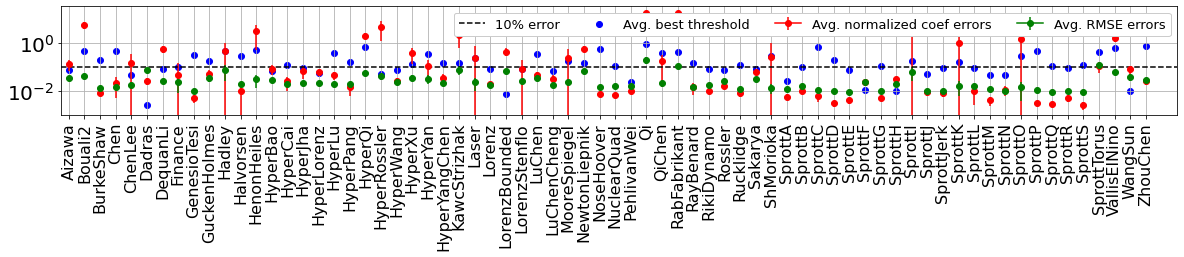

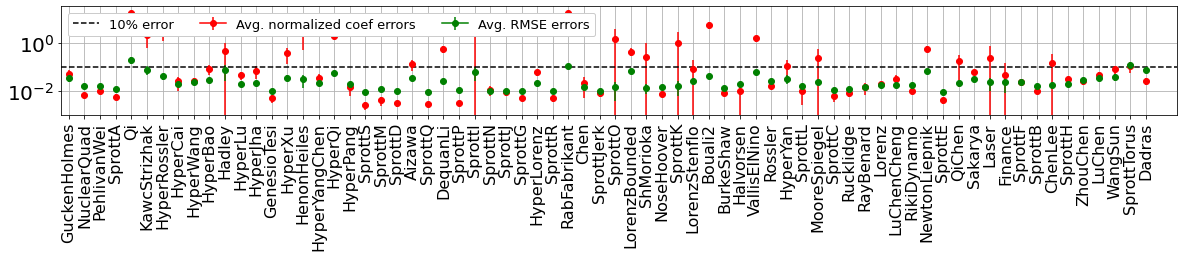

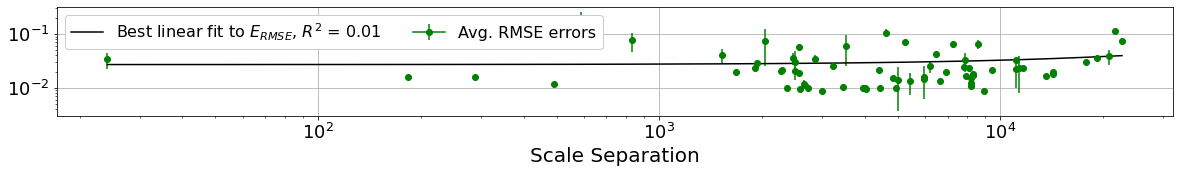

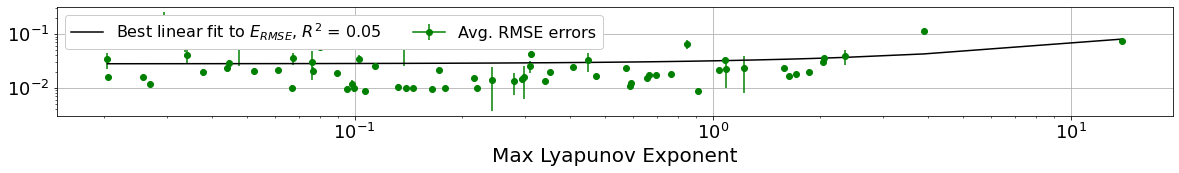

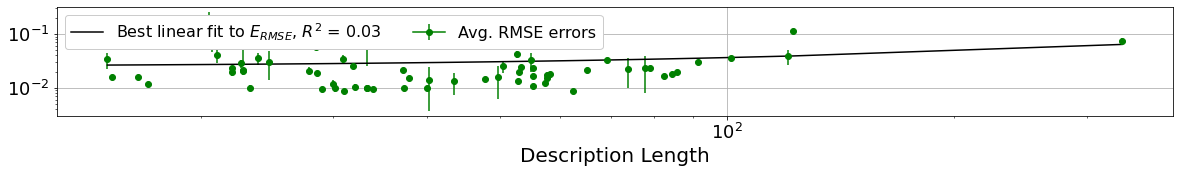

In [8]:
plt.figure(figsize=(20, 2))
for i, attractor_name in enumerate(systems_list):
    coef_avg_error = np.zeros(n_models)
    for j in range(n_models):
        coef_avg_error[j] = total_coefficient_error_normalized(
            true_coefficients[i],
            np.array(predicted_coefficients[attractor_name])[0, j, :, :]
        )
    avg_rmse_error = np.mean(np.ravel(abs(np.array(xdot_rmse_errors[attractor_name]))))
    std_rmse_error = np.std(np.ravel(abs(np.array(xdot_rmse_errors[attractor_name]))))
    if i == 0:
        plt.errorbar(
            i,
            np.mean(coef_avg_error),
            np.std(coef_avg_error),
            c="r",
            marker='o',
            label="Avg. normalized coef errors",
        )
        plt.errorbar(
            i,
            avg_rmse_error,
            std_rmse_error,
            c="g",
            marker='o',
            label="Avg. RMSE errors",
        )
        plt.scatter(
            i, best_threshold_values[attractor_name], c="b",
            label="Avg. best threshold"
        )
    else:
        plt.errorbar(
            i,
            np.mean(coef_avg_error),
            np.std(coef_avg_error),
            c="r",
            marker='o',
        )
        plt.errorbar(
            i,
            avg_rmse_error,
            std_rmse_error,
            c="g",
            marker='o',
        )
        plt.scatter(
            i, best_threshold_values[attractor_name], c="b",
        )
plt.grid(True)
plt.yscale("log")
plt.plot(
    np.linspace(-0.5, num_attractors + 1, num_attractors),
    0.1 * np.ones(num_attractors),
    "k--",
    label="10% error",
)
plt.legend(
    #["10% normalized error", "$E_{coef}$", "$E_{RMSE}$", "Optimal threshold"],
    framealpha=1.0,
    ncol=4,
    fontsize=13,
)
ax = plt.gca()
plt.xticks(np.arange(num_attractors), rotation="vertical", fontsize=16)
plt.xlim(-0.5, num_attractors + 1)
systems_list_cleaned = []
for i, system in enumerate(systems_list):
    if system == "GuckenheimerHolmes":
        systems_list_cleaned.append("GuckenHolmes")
    elif system == "NuclearQuadrupole":
        systems_list_cleaned.append("NuclearQuad")
    elif system == "RabinovichFabrikant":
        systems_list_cleaned.append("RabFabrikant")
    elif system == "KawczynskiStrizhak":
        systems_list_cleaned.append("KawcStrizhak")
    elif system == "RikitakeDynamo":
        systems_list_cleaned.append("RikiDynamo")
    elif system == "ShimizuMorioka":
        systems_list_cleaned.append("ShMorioka")
    elif system == "HindmarshRose":
        systems_list_cleaned.append("Hindmarsh")
    elif system == "RayleighBenard":
        systems_list_cleaned.append("RayBenard")
    else:
        systems_list_cleaned.append(system)
ax.set_xticklabels(np.array(systems_list_cleaned))
# if normalize_columns:
#     plt.ylim(1e-4, 1e4)
# else:
#     plt.ylim(1e-4, 1e1)
plt.yticks(fontsize=20)
plt.savefig("model_summary_without_added_noise_Algo3.pdf")

# Repeat the plot, but reorder things by the amount of scale separation
scale_sort = np.argsort(scale_list_avg)
coefficients_reordered = np.array(true_coefficients)[scale_sort]
scale_list_sorted = np.sort(scale_list_avg)
systems_list_sorted = np.array(systems_list)[scale_sort]
cerrs = []
rmse_errs = []
plt.figure(figsize=(20, 2))
for i, attractor_name in enumerate(systems_list_sorted):
    coef_avg_error = np.zeros(n_models)
    for j in range(n_models):
        coef_avg_error[j] = total_coefficient_error_normalized(
            coefficients_reordered[i],
            np.array(predicted_coefficients[attractor_name])[0, j, :, :]
        )
    avg_rmse_error = np.mean(np.ravel(abs(np.array(xdot_rmse_errors[attractor_name]))))
    std_rmse_error = np.std(np.ravel(abs(np.array(xdot_rmse_errors[attractor_name]))))
    if i == 0:
        plt.errorbar(
            i,
            np.mean(coef_avg_error),
            np.std(coef_avg_error),
            c="r",
            marker='o',
            label="Avg. normalized coef errors",
        )
        plt.errorbar(
            i,
            avg_rmse_error,
            std_rmse_error,
            c="g",
            marker='o',
            label="Avg. RMSE errors",
        )
    else:
        plt.errorbar(
            i,
            np.mean(coef_avg_error),
            np.std(coef_avg_error),
            c="r",
            marker='o',
        )
        plt.errorbar(
            i,
            avg_rmse_error,
            std_rmse_error,
            c="g",
            marker='o',
        )
    rmse_errs.append(avg_rmse_error)
    cerrs.append(np.mean(coef_avg_error))

plt.grid(True)
plt.yscale("log")
plt.plot(
    np.linspace(-0.5, num_attractors + 1, num_attractors),
    0.1 * np.ones(num_attractors),
    "k--",
    label="10% error",
)
plt.legend(
    #["10% normalized error", "$E_{coef}$"],
    framealpha=1.0,
    ncol=4,
    fontsize=13,
    loc="upper left",
)
ax = plt.gca()
plt.xticks(np.arange(num_attractors), rotation="vertical", fontsize=16)
plt.xlim(-0.5, num_attractors + 1)
ax.set_xticklabels(np.array(systems_list_cleaned)[scale_sort])
# plt.ylim(1e-4, 1e1)
plt.yticks(fontsize=20)
plt.savefig("model_summary_scaleSeparation_without_added_noise_Algo3.pdf")

from scipy.stats import linregress

slope, intercept, r_value, p_value, std_err = linregress(
    scale_list_sorted, rmse_errs
)
slope_coef, intercept_coef, r_value_coef, p_value_coef, std_err_coef = linregress(
    scale_list_sorted, cerrs
)
print(slope, intercept, r_value, p_value, std_err)
print("R^2 value for RMSE error = ", r_value**2)
print("R^2 value for coef error = ", r_value_coef**2)

plt.figure(figsize=(20, 2))
for i, attractor_name in enumerate(systems_list_sorted):
    coef_avg_error = np.zeros(n_models)
    for j in range(n_models):
        coef_avg_error[j] = total_coefficient_error_normalized(
            coefficients_reordered[i],
            np.array(predicted_coefficients[attractor_name])[0, j, :, :]
        )
    avg_rmse_error = np.mean(np.ravel(abs(np.array(xdot_rmse_errors[attractor_name]))))
    std_rmse_error = np.std(np.ravel(abs(np.array(xdot_rmse_errors[attractor_name]))))
    if i == 0:
        plt.errorbar(
            scale_list_sorted[i],
            avg_rmse_error,
            std_rmse_error,
            c="g",
            marker='o',
            label="Avg. RMSE errors",
        )
    else:
        plt.errorbar(
            scale_list_sorted[i],
            avg_rmse_error,
            std_rmse_error,
            c="g",
            marker='o',
        )
plt.plot(scale_list_sorted, slope * scale_list_sorted + intercept, "k", 
         label="Best linear fit to $E_{RMSE}$, $R^2$ = " + "{0:.2f}".format(r_value**2))

plt.xscale("log")
plt.grid(True)
plt.yscale('log')
plt.legend(
    loc="upper left",
    framealpha=1.0,
    ncol=4,
    fontsize=16,
)
ax = plt.gca()
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel('Scale Separation', fontsize=20)
plt.savefig("model_summary_ScaleSeparation.pdf")

### now chaos
scale_list_sorted = np.sort(lyap_list)
slope, intercept, r_value, p_value, std_err = linregress(
    scale_list_sorted, rmse_errs
)
slope_coef, intercept_coef, r_value_coef, p_value_coef, std_err_coef = linregress(
    scale_list_sorted, cerrs
)
print(slope, intercept, r_value, p_value, std_err)
print("R^2 value for RMSE error = ", r_value**2)
print("R^2 value for coef error = ", r_value_coef**2)

plt.figure(figsize=(20, 2))
for i, attractor_name in enumerate(systems_list_sorted):
    coef_avg_error = np.zeros(n_models)
    for j in range(n_models):
        coef_avg_error[j] = total_coefficient_error_normalized(
            coefficients_reordered[i],
            np.array(predicted_coefficients[attractor_name])[0, j, :, :]
        )
    avg_rmse_error = np.mean(np.ravel(abs(np.array(xdot_rmse_errors[attractor_name]))))
    std_rmse_error = np.std(np.ravel(abs(np.array(xdot_rmse_errors[attractor_name]))))
    if i == 0:
        plt.errorbar(
            scale_list_sorted[i],
            avg_rmse_error,
            std_rmse_error,
            c="g",
            marker='o',
            label="Avg. RMSE errors",
        )
    else:
        plt.errorbar(
            scale_list_sorted[i],
            avg_rmse_error,
            std_rmse_error,
            c="g",
            marker='o',
        )
plt.plot(scale_list_sorted, slope * scale_list_sorted + intercept, "k", 
         label="Best linear fit to $E_{RMSE}$, $R^2$ = " + "{0:.2f}".format(r_value**2))

plt.xscale("log")
plt.grid(True)
plt.yscale('log')
plt.legend(
    loc="upper left",
    framealpha=1.0,
    ncol=4,
    fontsize=16,
)
ax = plt.gca()
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel('Max Lyapunov Exponent', fontsize=20)
plt.savefig("model_summary_Chaos.pdf")

### now description length
scale_list_sorted = np.array(np.sort(medl_list), dtype=float)
slope, intercept, r_value, p_value, std_err = linregress(
    scale_list_sorted, rmse_errs
)
slope_coef, intercept_coef, r_value_coef, p_value_coef, std_err_coef = linregress(
    scale_list_sorted, cerrs
)
print(slope, intercept, r_value, p_value, std_err)
print("R^2 value for RMSE error = ", r_value**2)
print("R^2 value for coef error = ", r_value_coef**2)

plt.figure(figsize=(20, 2))
for i, attractor_name in enumerate(systems_list_sorted):
    coef_avg_error = np.zeros(n_models)
    for j in range(n_models):
        coef_avg_error[j] = total_coefficient_error_normalized(
            coefficients_reordered[i],
            np.array(predicted_coefficients[attractor_name])[0, j, :, :]
        )
    avg_rmse_error = np.mean(np.ravel(abs(np.array(xdot_rmse_errors[attractor_name]))))
    std_rmse_error = np.std(np.ravel(abs(np.array(xdot_rmse_errors[attractor_name]))))
    if i == 0:
        plt.errorbar(
            scale_list_sorted[i],
            avg_rmse_error,
            std_rmse_error,
            c="g",
            marker='o',
            label="Avg. RMSE errors",
        )
    else:
        plt.errorbar(
            scale_list_sorted[i],
            avg_rmse_error,
            std_rmse_error,
            c="g",
            marker='o',
        )
plt.plot(scale_list_sorted, slope * scale_list_sorted + intercept, "k", 
         label="Best linear fit to $E_{RMSE}$, $R^2$ = " + "{0:.2f}".format(r_value**2))

plt.xscale("log")
plt.grid(True)
plt.yscale('log')
plt.legend(
    loc="upper left",
    framealpha=1.0,
    ncol=4,
    fontsize=16,
)
ax = plt.gca()
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel('Description Length', fontsize=20)
plt.savefig("model_summary_DescriptionLength.pdf")

plt.show()

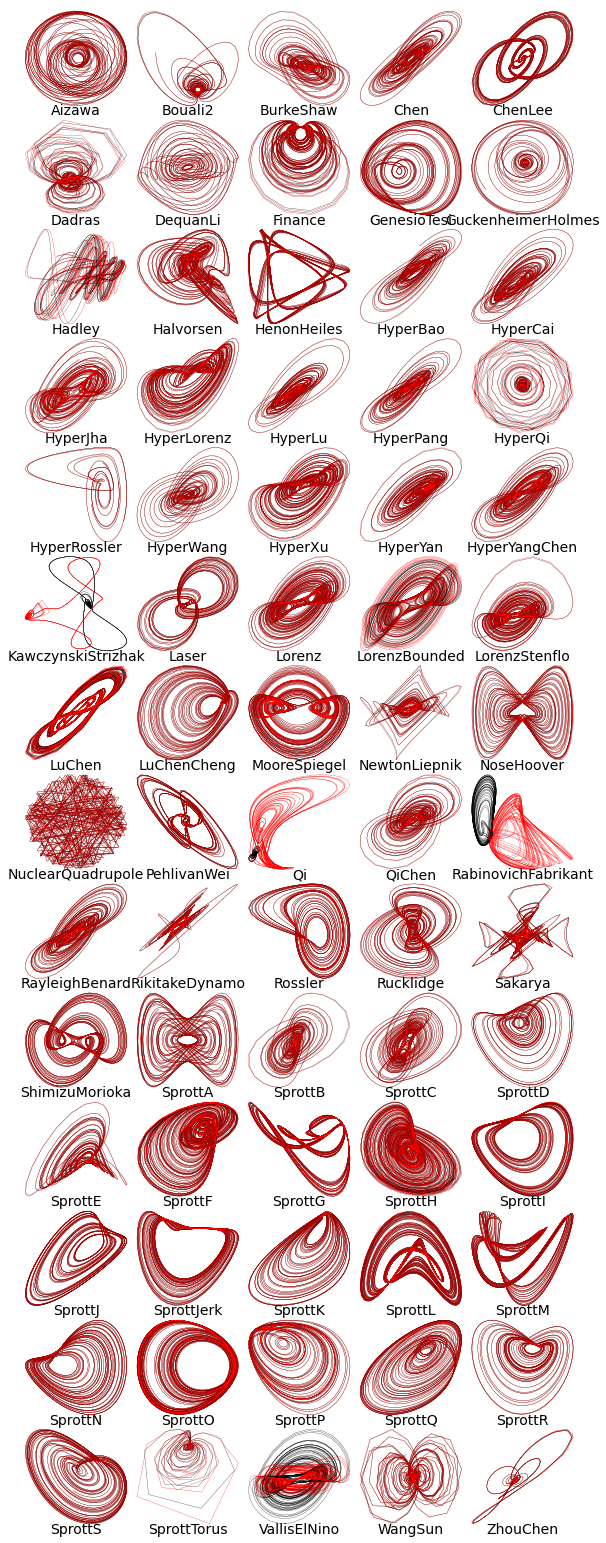

In [9]:

# Plot the training and testing trajectories for all the chaotic systems
num_cols = 5
num_rows = int(np.ceil(len(all_sols_train) / num_cols))
fig = plt.figure(figsize=(num_cols * 2, num_rows * 2))

gs = plt.matplotlib.gridspec.GridSpec(num_rows, num_cols)
gs.update(wspace=0.0, hspace=0.05) 

ntime = len(all_t_train['Aizawa'][0])

for i, attractor_name in enumerate(systems_list):
    x_dot_test = np.array(x_dot_tests[i]) # .reshape(n_trajectories * ntime, dimension_list[i])
    x_dot_test_pred = np.array(x_dot_test_preds[i]).reshape(n_trajectories, ntime, dimension_list[i])
    plt.subplot(gs[i])
    for j in range(n_trajectories):
        plt.plot(x_dot_test[j, :, 0], x_dot_test[j, :, 1], 'k', linewidth=0.25)
        plt.plot(x_dot_test_pred[j, :, 0], x_dot_test_pred[j, :, 1], 'r', linewidth=0.25)
    plt.title(attractor_name, y=-0.1, fontsize=14)
    plt.gca().axis('off')
    

0 Aizawa
1 Bouali2


/Users/alankaptanoglu/anaconda3/lib/python3.7/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


2 BurkeShaw
3 Chen
4 ChenLee
5 Dadras
6 DequanLi
7 Finance
8 GenesioTesi


/Users/alankaptanoglu/anaconda3/lib/python3.7/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


9 GuckenheimerHolmes
10 Hadley
11 Halvorsen
12 HenonHeiles


/Users/alankaptanoglu/anaconda3/lib/python3.7/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


13 HyperBao
14 HyperCai
15 HyperJha
16 HyperLorenz
17 HyperLu
18 HyperPang
19 HyperQi
20 HyperRossler
21 HyperWang
22 HyperXu
23 HyperYan
24 HyperYangChen
25 KawczynskiStrizhak
26 Laser
27 Lorenz
28 LorenzBounded
29 LorenzStenflo
30 LuChen
31 LuChenCheng
32 MooreSpiegel
33 NewtonLiepnik
34 NoseHoover
35 NuclearQuadrupole
36 PehlivanWei
37 Qi


/Users/alankaptanoglu/anaconda3/lib/python3.7/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/Users/alankaptanoglu/anaconda3/lib/python3.7/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/Users/alankaptanoglu/anaconda3/lib/python3.7/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/Users/alankaptanoglu/anaconda3/lib/python3.7/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quanti

38 QiChen
39 RabinovichFabrikant


/Users/alankaptanoglu/anaconda3/lib/python3.7/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


40 RayleighBenard
41 RikitakeDynamo
42 Rossler
43 Rucklidge
44 Sakarya
45 ShimizuMorioka
46 SprottA
47 SprottB
48 SprottC
49 SprottD


/Users/alankaptanoglu/anaconda3/lib/python3.7/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/Users/alankaptanoglu/anaconda3/lib/python3.7/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


50 SprottE
51 SprottF
52 SprottG
53 SprottH
54 SprottI


/Users/alankaptanoglu/anaconda3/lib/python3.7/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/Users/alankaptanoglu/anaconda3/lib/python3.7/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/Users/alankaptanoglu/anaconda3/lib/python3.7/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/Users/alankaptanoglu/anaconda3/lib/python3.7/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quanti

55 SprottJ


/Users/alankaptanoglu/anaconda3/lib/python3.7/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


56 SprottJerk


/Users/alankaptanoglu/anaconda3/lib/python3.7/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/Users/alankaptanoglu/anaconda3/lib/python3.7/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/Users/alankaptanoglu/anaconda3/lib/python3.7/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/Users/alankaptanoglu/anaconda3/lib/python3.7/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quanti

57 SprottK
58 SprottL


/Users/alankaptanoglu/anaconda3/lib/python3.7/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/Users/alankaptanoglu/anaconda3/lib/python3.7/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/Users/alankaptanoglu/anaconda3/lib/python3.7/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/Users/alankaptanoglu/anaconda3/lib/python3.7/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quanti

59 SprottM


/Users/alankaptanoglu/anaconda3/lib/python3.7/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


60 SprottN


/Users/alankaptanoglu/anaconda3/lib/python3.7/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


61 SprottO
62 SprottP
63 SprottQ


/Users/alankaptanoglu/anaconda3/lib/python3.7/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


64 SprottR
65 SprottS
66 SprottTorus
67 VallisElNino


/Users/alankaptanoglu/anaconda3/lib/python3.7/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/Users/alankaptanoglu/anaconda3/lib/python3.7/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/Users/alankaptanoglu/anaconda3/lib/python3.7/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/Users/alankaptanoglu/anaconda3/lib/python3.7/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quanti

68 WangSun
69 ZhouChen


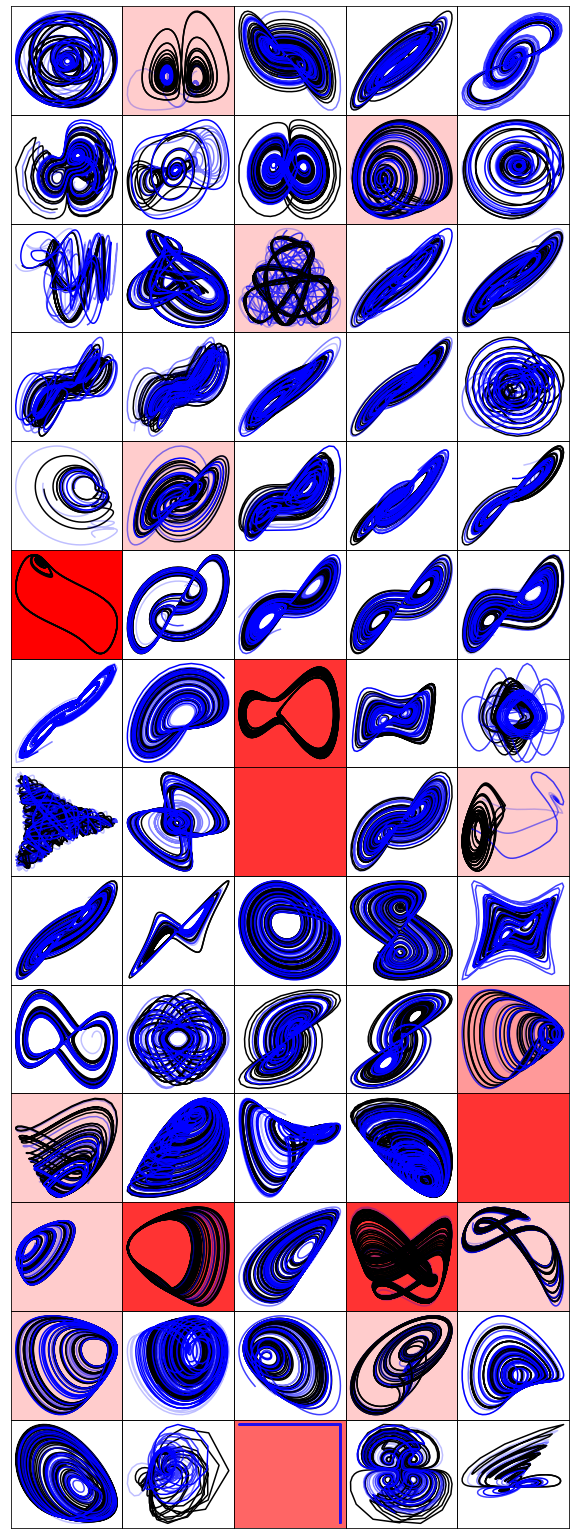

In [10]:

num_cols = 5
num_rows = int(np.ceil(len(all_sols_train) / num_cols))
plt.figure(figsize=(num_cols * 2, num_rows * 2))
gs = plt.matplotlib.gridspec.GridSpec(num_rows, num_cols)
gs.update(wspace=0.0, hspace=0.0) 

for i, attractor in enumerate(systems_list):
    print(i, attractor)
    fig = plt.subplot(gs[i])
    num_bounded = n_trajectories
    for j in range(n_trajectories):
        plt.plot(test_trajectories[attractor][:, j, 0], test_trajectories[attractor][:, j, 1], 'k') #, test_trajectories[attractor][:, j, 2], 'k')
        x0 = test_trajectories[attractor][0, j, :] + (np.random.rand(dimension_list[i]) - 0.5) * np.linalg.norm(test_trajectories[attractor][:, j, :]) / 100.0
        models[i].feature_library.fit(np.zeros(dimension_list[i]))
        x_pred = models[i].simulate(
            x0, 
            t=test_trajectories_time[attractor][:, j],
            integrator='odeint'
        )
        if np.linalg.norm(x_pred) > np.linalg.norm(test_trajectories[attractor][:, j, 0]) * 10:
            num_bounded -= 1
        else:
            plt.plot(x_pred[:, 0], x_pred[:, 1], 'b', alpha=(j / (n_trajectories - 1)))
        ax = plt.gca()
        fig.patch.set_facecolor('r')
    fig.patch.set_alpha(1 - (num_bounded / n_trajectories))

    #plt.title(str(num_bounded) + '/' + str(num_trajectories))
    plt.grid(True)
    plt.yticks([])
    plt.xticks([])

In [11]:
# for j in range(num_attractors):
#     coef_flat = np.ravel(models[j].optimizer.coef_)
#     for i in range(len(coef_flat)):
#         if abs(coef_flat[i]) < 1e-2:
#             coef_flat[i] = 0.0
#     models[j].optimizer.coef_ = coef_flat.reshape(models[j].optimizer.coef_.shape)
#     print(models[j].optimizer.coef_)